### Fingerprint
A técnica de Fingerprint envolve a criação de um repositório de dados que contém amostras de informações, tais como potência do sinal, tempo de avanço e outros parâmetros que são característicos de uma região específica. O princípio subjacente a este algoritmo reside em utilizar esse repositório como um ponto de referência, no qual é possível comparar os dados coletados em uma localização desconhecida com as informações armazenadas no banco de dados. Isso possibilita a estimativa de qual ponto no banco de dados é mais similar à posição atual do objeto de interesse.

O algoritmo Fingerprint utiliza o cálculo da distância euclidiana, considerando as perdas de sinal das estações rádio base como características e se inspira no conceito de Fingerprint. Este algoritmo, que se baseia em aprendizado de máquina, adota uma abordagem de regressão linear. Ele utiliza as perdas de sinal das estações rádio base como entradas e gera como saída uma estimativa da latitude e longitude do objeto de interesse.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from branca.element import Figure
import folium

In [3]:
# Carregando os dados
df = pd.read_csv("../../project_files/03_processed_files/meds_train_alunos.csv")


In [4]:
df.head()


,Unnamed: 0.1,Unnamed: 0,id_ponto,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,num_lat_bts,num_long_bts,flag_indoor
0,0,0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,1
1,1,1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,1
2,2,2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,1
3,3,3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,4.0,7.0,2.0,-8.050390,-34.959630,0
4,4,4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,1


In [5]:
X = df[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
y = df[['id_ponto','num_lat_bts', 'num_long_bts']]

In [6]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Distância Euclidiana

In [7]:
import math

def euclidean_distance(vector, w_vector):
  # Calcula a distância euclidiana entre dois vetores.
    return vector_magnitude(subtract_vectors(vector, w_vector))

def vector_magnitude(vector):
# Calcula a magnitude (ou comprimento) de um vetor.
    return math.sqrt(square_sum(vector))

def dot_product(vector, w_vector):
 # Calcula o produto escalar de dois vetores.
    return sum(v_i * w_i for v_i, w_i in zip(vector, w_vector))

def subtract_vectors(vector, w_vector):
 # Subtrai dois vetores e retorna o resultado.
    return [v_i - w_i for v_i, w_i in zip(vector, w_vector)]

def square_sum(vector):
  # Calcula a soma dos quadrados dos componentes de um vetor.
    return dot_product(vector, vector)

In [8]:
"""
    Estima a posição de um dispositivo com base em sua impressão digital (fingerprint).
    
    Parâmetros:
    - v: vetor de impressão digital do dispositivo.
    - df: DataFrame contendo as impressões digitais de referência e suas respectivas posições.
    
    Retorna:
    - A posição (latitude e longitude) do fingerprint de referência mais próxima do vetor v.
"""
def fingerprint(vector, df):
    # Calcula a distância entre o vetor de fingerprint v e cada vetor no DataFrame.
    # A função distance é usada para calcular a distância, que precisa ser definida em algum lugar do código.
    df['distance'] = [euclidean_distance(list(w), list(vector)) for w in df.values.tolist()]
    
    # Ordena o DataFrame com base nas distâncias em ordem crescente.
    df = df.sort_values(by='distance', ascending=True)
    
    # Redefine o índice do DataFrame para que o índice 0 seja o vetor do fingerprint mais próximo.
    df = df.reset_index()
    
    # Retorna a latitude e a longitude do fingerprint de referência mais próxima.
    return df.loc[0, ['num_lat_bts', 'num_long_bts']]


In [9]:
v = [106,	122,	114,	123,	130,	111]
df_ = X_train.copy()
df_['num_lat_bts'] = y_train['num_lat_bts']
df_['num_long_bts'] = y_train['num_long_bts']
fingerprint(v,df_)

num_lat_bts     -8.05420
num_long_bts   -34.94651
Name: 0, dtype: float64

In [10]:
# Previsoes fingerprint
Y_pred = [list(fingerprint(v,df_)) for _,v in X_test.iterrows()]


In [11]:

df2 = y_test.copy()
df2['lat_pred'] = [lat for lat,_ in Y_pred]
df2['lon_pred'] = [lon for _,lon in Y_pred]

In [12]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']

In [13]:
df2.describe()

,id_ponto,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
count,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000,1353.000000
mean,4814.705839,-8.054523,-34.951840,-8.054503,-34.951845,-0.000020,0.000005
std,2820.223453,0.002374,0.002319,0.002346,0.002345,0.000616,0.000565
min,18.000000,-8.059490,-34.959840,-8.059520,-34.959830,-0.011010,-0.007660
25%,2271.000000,-8.055720,-34.951736,-8.055684,-34.951736,0.000000,0.000000
50%,4792.000000,-8.055494,-34.951597,-8.055494,-34.951597,0.000000,0.000000
75%,7308.000000,-8.055230,-34.951331,-8.055170,-34.951331,0.000000,0.000000
max,9673.000000,-8.046420,-34.945120,-8.046420,-34.945110,0.004480,0.005930


In [14]:
df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [15]:
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]

In [16]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']
     

In [17]:

df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [18]:
import math
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]
     

In [19]:
df2['diff_metros'].describe()


count    1353.000000
mean        7.076586
std        24.835608
min         0.000000
25%         0.000000
50%         0.000000
75%         2.247370
max       414.044501
Name: diff_metros, dtype: float64

### Mapa de comparação: posições preditas vs. posições reais


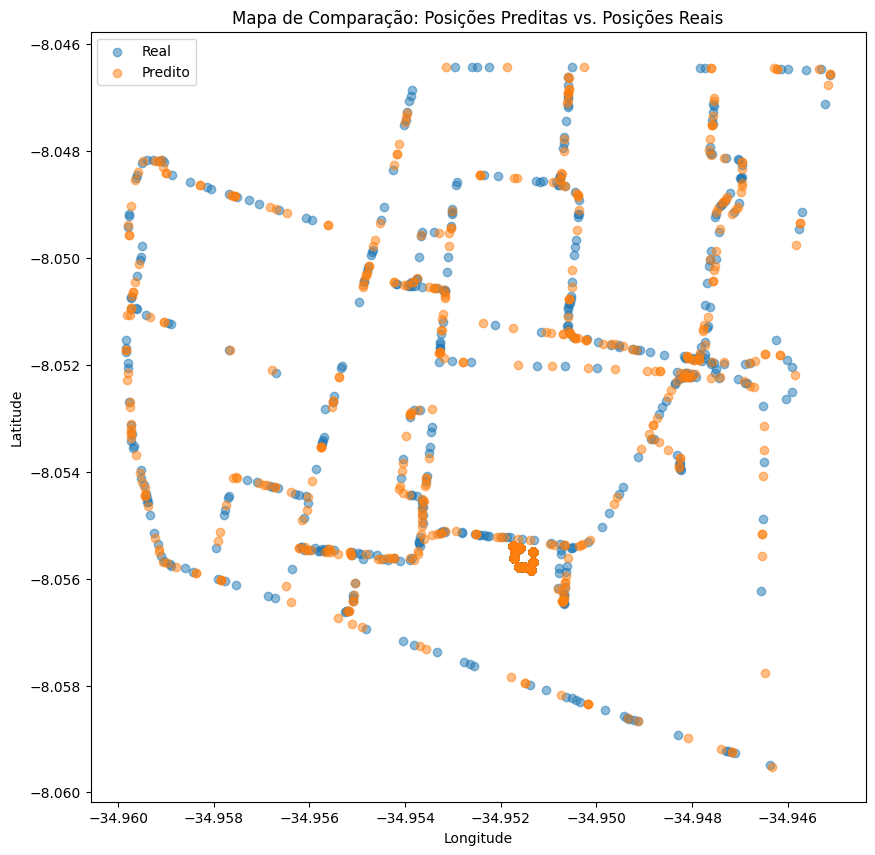

In [20]:
import numpy as np
Y_pred_array = np.array(Y_pred)
plt.figure(figsize=(10, 10))
plt.scatter(y_test['num_long_bts'], y_test['num_lat_bts'], label='Real', alpha=0.5)
plt.scatter(Y_pred_array[:, 1], Y_pred_array[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Comparação: Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()




In [29]:
import folium

os = folium.Map(location=[-8.0556479,-34.9532624], zoom_start=15)

for _, row in df2.iterrows():
    # Adicionando os pontos reais (BTS)
    folium.CircleMarker(
        location=[row["num_lat_bts"], row["num_long_bts"]],
        radius=5,
        color='blue',
        fill_opacity=0.7
    ).add_to(os)
    
    # Adicionando os pontos previstos
    folium.CircleMarker(
        location=[row["lat_pred"], row["lon_pred"]],
        radius=5,
        color='orange',
        fill_opacity=0.3
    ).add_to(os)
    
    # Conectando o ponto real ao ponto previsto com uma linha
    folium.PolyLine(
        locations=[[row["num_lat_bts"], row["num_long_bts"]], [row["lat_pred"], row["lon_pred"]]],
        color='grey',
        weight=1.5
    ).add_to(os)

os


### Avaliação do Modelo

In [22]:
# Avaliação do modelo
y_test_subset = y_test[['num_lat_bts', 'num_long_bts']]

mse = mean_squared_error(y_test_subset, Y_pred_array)
mae = mean_absolute_error(y_test_subset, Y_pred_array)


In [23]:

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 3.4966407982268916e-07
Mean Absolute Error (MAE): 0.0001458019216556416


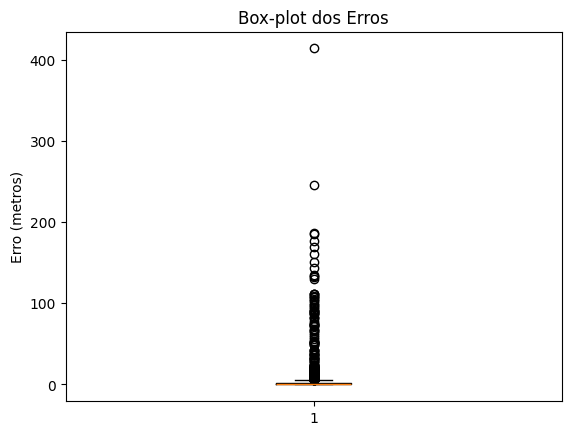

In [24]:
# Histograma e Box-Plot dos Erros
plt.boxplot(df2['diff_metros'])
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()

<Axes: >

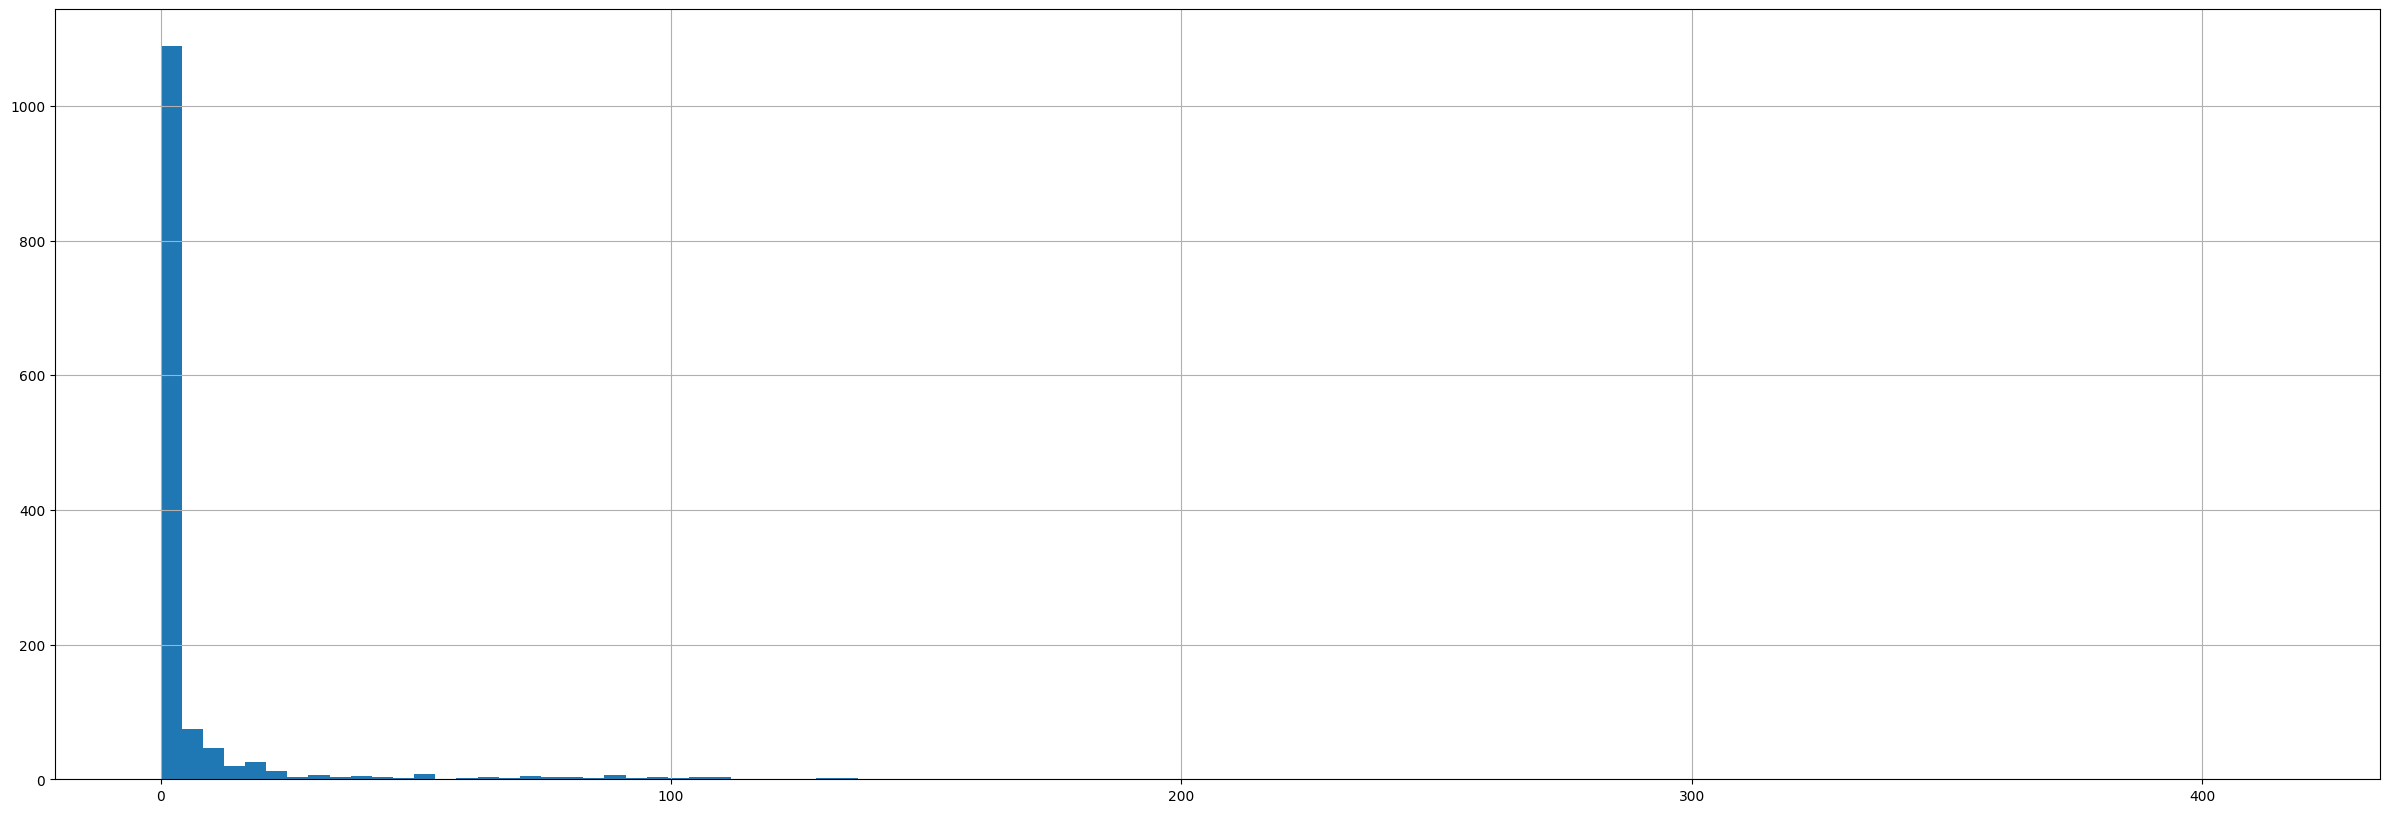

In [25]:
# Histograma e Box-Plot dos Erros
df2['diff_metros'].hist(bins=100, figsize=(30,10))

In [26]:
df2.head()

,id_ponto,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff,lat_diff_metros,lon_diff_metros,diff_metros
5997,9133,-8.048630,-34.952930,-8.048440,-34.952430,-0.00019,-0.00050,-5.8653,-15.4350,16.511843
4882,4445,-8.055506,-34.951693,-8.055506,-34.951693,0.00000,0.00000,0.0000,0.0000,0.000000
2955,6593,-8.055786,-34.951505,-8.055786,-34.951505,0.00000,0.00000,0.0000,0.0000,0.000000
2303,9502,-8.047130,-34.950590,-8.046910,-34.950600,-0.00022,0.00001,-6.7914,0.3087,6.798412
496,8192,-8.051920,-34.947800,-8.051910,-34.947850,-0.00001,0.00005,-0.3087,1.5435,1.574067


In [27]:
df_final = df2[['id_ponto','lat_pred','lon_pred']]
df_final.to_csv("../../project_files/03_processed_files/Resultados_Equipe1_MetodoFingerprint.csv")